In [1]:
%pip install qiskit

Note: you may need to restart the kernel to use updated packages.


In [1]:
from qiskit import *
from qiskit.visualization import *
from qiskit.circuit.library import MCPhaseGate
import qiskit.quantum_info as qi
import numpy as np
import pandas
import matplotlib.pyplot as plt


from random import *
from math import *

sim = Aer.get_backend('aer_simulator')
sim.set_options(device = 'GPU')

In [2]:

def phase_normalize(alfa,mn,mx):
  return ((alfa - mn) / (mx - mn))  * (pi/2)

def phase_denormalize(norm,mn,mx):
  return ((norm * (mx - mn)) / (pi/2)) + mn

def Uw_phi(basis,phi,n):
  reg_q = QuantumRegister(n,"qr")
  circ_Uwp = QuantumCircuit(reg_q)
  neg = []
  for i,bit in enumerate(basis):
    if bit == "0":
      neg.append(i)
      circ_Uwp.x(i)
  circ_Uwp.append(MCPhaseGate(-phi,n-1),reg_q)
  for i in neg:
    circ_Uwp.x(i)
  circ_Uwp.barrier()
  return circ_Uwp

def Uw(W_phi, n):
  reg_q = QuantumRegister(n,"qr")
  circ_Uw = QuantumCircuit(reg_q)

  for i in range(1,len(W_phi)):
    basis = bin(i)[2:]
    while(len(basis) < n):
      basis = '0' + basis
    circ_Uw.compose(Uw_phi(basis,W_phi[i] - W_phi[0],n),reg_q,inplace = True)

  circ_Uw.h(reg_q)
  return circ_Uw

def Ui_theta(basis,theta,n):
  reg_q = QuantumRegister(n,"qr")
  circ_Uit = QuantumCircuit(reg_q)
  neg = []
  for i,bit in enumerate(basis):
    if bit == "0":
      neg.append(i)
      circ_Uit.x(i)
  circ_Uit.append(MCPhaseGate(theta,n-1),reg_q)
  for i in neg:
    circ_Uit.x(i)
  circ_Uit.barrier()
  return circ_Uit

def Ui(train_set_x, n):
  reg_q = QuantumRegister(n,"qr")
  circ_Ui = QuantumCircuit(reg_q)
  circ_Ui.h(reg_q)
  for i in range(1,len(train_set_x)):
    basis = bin(i)[2:]
    while(len(basis) < n):
      basis = '0' + basis
    circ_Ui.compose(Ui_theta(basis,train_set_x[i] - train_set_x[0],n),reg_q,inplace = True)
  return circ_Ui


def PerceptronCircuit(train_set_x, w_set, n):
    reg_q = QuantumRegister(n,"qr")
    reg_aux = QuantumRegister(1, "aux")
    cla_aux = ClassicalRegister(1)
    total = n + 1
    circ_perc = QuantumCircuit(reg_q,reg_aux,cla_aux)

    circ_perc.barrier()
    circ_perc.compose(Ui(train_set_x,n),range(n), inplace = True)
    circ_perc.compose(Uw(w_set,n),range(n), inplace = True)
    circ_perc.x(reg_q)
    circ_perc.mcx(reg_q,reg_aux)
    circ_perc.measure(reg_aux,cla_aux)
    return circ_perc




In [3]:

def initialize(sz):
    w = np.array([uniform(0,pi/2) for i in range(sz)])
    return w

# tem que estar normalizado
def get_activation(w,train_set_x,num_shots = 8192):
    m = len(train_set_x[0])
    n = ceil(log2(m))
    A = np.array([])
    w_sent = phase_normalize(w, np.min(w), np.max(w))
    train_set_x_sent = phase_normalize(train_set_x, 0, 255)
    for pos,train_input in enumerate(train_set_x_sent):
        model = PerceptronCircuit(train_input, w_sent, n)
        qobj = assemble(model)   
        counts = sim.run(qobj,shots = num_shots).result().get_counts()
        if "1" in counts:
            A = np.append(A,counts["1"]/ num_shots)
        else:
            A = np.append(A,0.)
    return A

def get_dJ(w):
    phi = phase_normalize(w, np.min(w), np.max(w))
    theta = phase_normalize(train_set_x, 0, 255)
    set_size = train_set_x.shape[0]
    u = theta - phi         # theta - phi
    c = np.cos(u)           # cos(theta - phi)
    C = c.sum(axis = 1).reshape(1,set_size).T
    s = np.sin(u)
    S = s.sum(axis = 1).reshape(1,set_size).T
    A = (C * C + S * S) / 2**(2 * n)
    return (2 * (s*C - c*S) / 2**(2 * n)) * A/set_size



def get_A(w,train_set_x,n):## Função exata de A
    phi = phase_normalize(w, np.min(w), np.max(w))
    theta = phase_normalize(train_set_x, 0, 255)
    set_size = train_set_x.shape[0]
    u = theta - phi     
    c = np.cos(u)         
    C = c.sum(axis = 1).reshape(1,set_size).T
    s = np.sin(u)
    S = s.sum(axis = 1).reshape(1,set_size).T
    return (C * C + S * S) / 2**(2 * n)
            
    return w

In [4]:
import fiftyone as fo
import fiftyone.zoo as foz
import fiftyone.utils.splits as fous

dataset = foz.load_zoo_dataset(
    "open-images-v6", 
    split="validation", 
    label_types=["detections", "classifications"], 
    classes=["Cat"],
    max_samples=500,
    seed=51,
    shuffle=True,
    dataset_name="open-images-cat-dog",
)

dog_subset = foz.load_zoo_dataset(
    "open-images-v6", 
    split="validation", 
    label_types=["detections", "classifications"], 
    classes=["Dog"],
    max_samples=500,
    seed=51,
    shuffle=True,
    dataset_name="dog-subset",
)


NumExpr defaulting to 8 threads.
Only found 345 (<500) samples matching your requirements
Necessary images already downloaded
Existing download of split 'validation' is sufficient
Loading 'open-images-v6' split 'validation'
 100% |█████████████████| 345/345 [2.3s elapsed, 0s remaining, 163.4 samples/s]      
Dataset 'open-images-cat-dog' created
Necessary images already downloaded
Existing download of split 'validation' is sufficient
Loading 'open-images-v6' split 'validation'
 100% |█████████████████| 500/500 [3.5s elapsed, 0s remaining, 125.2 samples/s]      
Dataset 'dog-subset' created


In [5]:

dataset.merge_samples(dog_subset)
dataset.shuffle(seed=51)
fo.launch_app(dataset)
total = len(dataset)




NumExpr defaulting to 8 threads.


In [6]:
dataset_test = fo.Dataset(name = "test")
dataset_train = fo.Dataset(name = "train")
for sample in dataset:
    if random() >= 0.2:
        dataset_train.add_sample(sample)
    if  random() >= 0.8:
        dataset_test.add_sample(sample)


In [7]:

from PIL import Image,ImageOps

def load_params():
    w = np.load("./params/w.npy")
    Hyperparameters = np.load("./params/Hyperparameters.npy")
    return w, Hyperparameters
    
dim = 16
def load_images(path):
    images = np.array([])
    images = images.reshape(0,dim * dim)
    for filename in os.listdir(path):
        f = os.path.join(path, filename)
        if os.path.isfile(f):
            image_np = load_image(f)
            images = np.vstack((images,image_np[0]))
    return images

def load_image(f):
    image = ImageOps.grayscale(Image.open(f))
    image = image.resize((dim,dim))
    image_np = np.array(image)
    image_np = image_np.reshape(1,dim * dim)
    return image_np


def prepare_images_labels(dataset):
    set_y = np.zeros(len(dataset))
    set_x = np.array([])
    set_x = set_x.reshape(0,dim * dim)
    for pos,i in enumerate(dataset):
        image_np = load_image(i["filepath"])
        set_x = np.vstack((set_x,image_np[0]))
        for j in range(len(i.positive_labels.to_dict()["classifications"])):
            if i.positive_labels.to_dict()["classifications"][j]['label'] == "Cat":
                set_y[pos] = 1
                
    return set_x, set_y
    
def load_data(dataset_train,dataset_test):
    train_set_x, train_set_y = prepare_images_labels(dataset_train)
    test_set_x, test_set_y = prepare_images_labels(dataset_test)
    #save_data_ararys(train_set_x,train_set_y,test_set_x,test_set_y)
    return train_set_x, train_set_y, test_set_x, test_set_y
    
train_set_x, train_set_y, test_set_x, test_set_y = load_data(dataset_train,dataset_test)  

In [52]:
from qiskit.algorithms.optimizers import SPSA

m = len(train_set_x[0])
set_size = len(train_set_y)
n = ceil(log2(m))
w = initialize(m)
Hyperparameters = {
"iterations" : 100,
"threshold" : 0.5,
}
def powerseries(eta=0.01, power=2, offset=0):
    k = 1
    while True:
        yield eta / ((k + offset) ** power)
        k += 1

def learning_rate():
    return powerseries(449.860244892404292, 0.602, 0)

def perturbation():
    return powerseries(0.1,  0.101)

spsa = SPSA(maxiter=Hyperparameters["iterations"],learning_rate=learning_rate,perturbation=perturbation)
costs = []

    
def loss_func(w):
    set_size = len(train_set_x)
    A = get_A(w,train_set_x,n)
    diff = A.reshape(set_size,1) - train_set_y.reshape(set_size,1)
    cost = np.sum(diff ** 2) / set_size
    print("Custo {}".format(cost))
    costs.append(cost)
    return cost

def predict(X, w, Hyperparameters):
   A = get_A(w,X,n)
   labels = np.array([1 if i > Hyperparameters["threshold"] else 0 for i in A])
   return labels

result = spsa.optimize(num_vars=1,objective_function=loss_func,gradient_function=get_dJ, initial_point = w)


SPSA: Starting optimization.
Custo 0.37548337389858594
Custo 0.38084767881501064
Iteration 1/101 done in 0.015488862991333008.
Custo 0.25458081422406226
Custo 0.2546011156198124
Iteration 2/101 done in 0.016725778579711914.
Custo 0.25485982180018607
Custo 0.2547195840186719
Iteration 3/101 done in 0.017620325088500977.
Custo 0.2546682098047362
Custo 0.25644370360722357
Iteration 4/101 done in 0.016731977462768555.
Custo 0.27792862456619954
Custo 0.2783689605703359
Iteration 5/101 done in 0.015659809112548828.
Custo 0.28343758391552165
Custo 0.2817730785551163
Iteration 6/101 done in 0.015654563903808594.
Custo 0.29913803320956084
Custo 0.2988645643705925
Iteration 7/101 done in 0.017412900924682617.
Custo 0.3012280383973401
Custo 0.2998724509508185
Iteration 8/101 done in 0.01435542106628418.
Custo 0.31080261631405465
Custo 0.3111955482705817
Iteration 9/101 done in 0.012202739715576172.
Custo 0.31310574542265224
Custo 0.3131340017932668
Iteration 10/101 done in 0.015027046203613281.
C

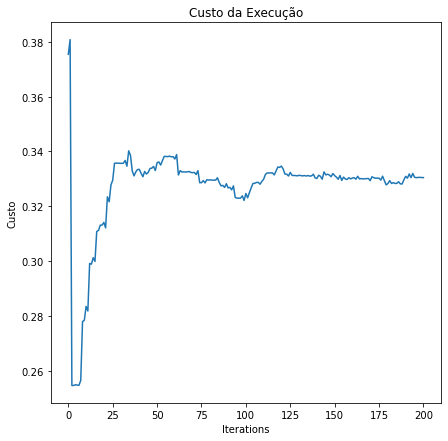

39.19597989949749


In [53]:
labels = predict(test_set_x,result[0],Hyperparameters)
np.save("../src/params/w_num.npy",result[0])
acc = (100 - np.mean(np.abs(labels - test_set_y)) * 100)
plt.clf()
plt.plot(costs, label = "Custo da i-ésima execução.")
plt.xlabel("Iterations")
plt.ylabel("Custo")
plt.title("Custo da Execução")
plt.savefig("train_cost.jpg")
plt.show()
print(acc)

In [33]:

m = len(train_set_x[0])
set_size = len(train_set_y)
n = ceil(log2(m))
def compare(w,train_set_x,n):
    A1 = get_A(w,train_set_x,n)
    A2 = get_activation(w,train_set_x)
    return A1,A2
A1,A2 = compare(w,train_set_x,n)


Total Assembly Time - 0.16427 (ms)


KeyboardInterrupt: 

0.013117727411277702 -0.014084742576746412


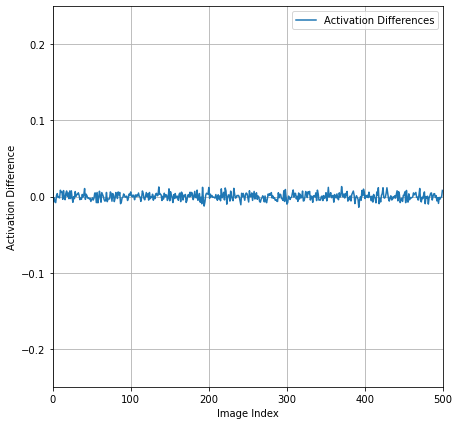

In [88]:
plt.clf()
A = A1 - A2.reshape(500,1)
plt.axis([0, 500, -0.25, 0.25])
plt.plot(A, label = "Activation Differences")
plt.xlabel("Image Index")
plt.ylabel("Activation Difference")
plt.legend()
mx_diff = np.max(A)
mn_diff = np.min(A)
print(mx_diff, mn_diff)
plt.legend()
plt.grid()
plt.savefig("Activation_Differences.jpg")
plt.show()

0.6080402010050251
0.6080402010050251
0.6080402010050251


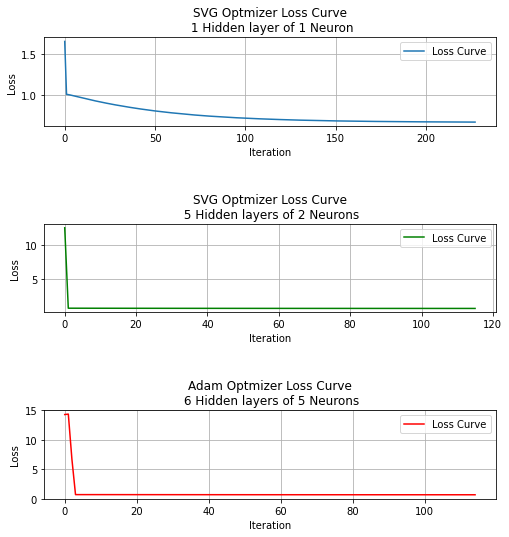

In [56]:
plt.rcParams["figure.figsize"] = (7,7)
fig, axs = plt.subplots(3)
fig.tight_layout()

from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(1, 1), random_state=1,max_iter=1000)
clf.fit(train_set_x, train_set_y)
print(clf.score(test_set_x, test_set_y))
axs[0].plot(list(clf.loss_curve_), label = "Loss Curve")
axs.flat[0].set(xlabel='Iteration', ylabel='Loss')
axs[0].set_title("SVG Optmizer Loss Curve\n 1 Hidden layer of 1 Neuron")
axs[0].legend()
axs[0].grid()


clf = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1,max_iter=1000)
clf.fit(train_set_x, train_set_y)
print(clf.score(test_set_x, test_set_y))
axs[1].plot(list(clf.loss_curve_), label = "Loss Curve", c= 'green')
axs.flat[1].set(xlabel='Iteration', ylabel='Loss')
axs[1].set_title("SVG Optmizer Loss Curve\n 5 Hidden layers of 2 Neurons")
axs[1].legend()
axs[1].grid()

clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(6, 5), random_state=1)
clf.fit(train_set_x, train_set_y)
print(clf.score(test_set_x, test_set_y))
axs[2].plot(list(clf.loss_curve_), label = "Loss Curve",c = 'red')
axs.flat[2].set(xlabel='Iteration', ylabel='Loss')
axs[2].set_title("Adam Optmizer Loss Curve\n 6 Hidden layers of 5 Neurons")
axs[2].legend()
axs[2].grid()
fig.subplots_adjust(hspace=1.1)
fig.savefig("loss_curve_adam_65.jpg",bbox_inches='tight')


In [16]:
from PIL import Image
import numpy as np

w, h = 16, 16
data = np.zeros((h,w))
for pos, t_in in enumerate(train_set_x):
    if(train_set_y[pos] == 1.0):
        data = np.array(t_in).reshape(w,h)
        img = Image.fromarray(data)
        img.show()
        t = input()
        print(t)
        if(t != 'S' and t != 's'):
            if img.mode != 'RGB':
                img = img.convert('RGB')
            img.resize((640,640))
            img.save("cat.png")
            break


s
s
n
